# Setup

In [2]:
import pandapower.networks as pnet
import pandas as pd
import numpy as np
import scipy as sp
import cvxpy as cp
import seaborn as sns
import mlflow
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy import sparse

In [3]:
%load_ext autoreload
%autoreload 2

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
import sys
sys.path.insert(1, '..')

from src.models.matrix_operations import make_real_vector, vectorize_matrix
from src.simulation.noise import add_polar_noise_to_measurement
from src.simulation.network import cross_multiply_measurements, make_measurements_matrix
from src.models.noise_transformation import power_covariance
from src.models.regression import ComplexRegression, ComplexLasso
from src.models.error_in_variable import TotalLeastSquares, SparseTotalLeastSquare
from src.simulation.load_profile import generate_gaussian_load
from src.simulation.network import add_load_power_control, make_y_bus
from src.simulation.simulation import run_simulation, get_current_and_voltage
from src.identification.error_metrics import error_metrics, fro_error
from src.models.noise_transformation import average_true_noise_covariance

# Network simulation

In [5]:
mlflow.set_experiment('Colinearity test')

In [6]:
np.random.seed(11)
n_experiments = 5
colinearity = np.empty(n_experiments)
errors = np.empty(n_experiments)

In [7]:
for k in tqdm(range(n_experiments), desc='outer loop', leave=True):
    net = pnet.create_kerber_landnetz_freileitung_2(p_load_mw=0.008*(k+1), q_load_mvar=0)
    nodes = net.bus.shape[0]
    steps = 400
    load_cv = 0.5
    current_magnitude_sd = 0.000001
    voltage_magnitude_sd = 0.0001
    phase_sd = 0.0001
    with mlflow.start_run(run_name=str('S-TLS with covariance, load = ' + str(8*(k+1)) + 'kW')):
        load_p, load_q = generate_gaussian_load(net.load.p_mw, net.load.q_mvar, load_cv, steps)
        controlled_net = add_load_power_control(net, load_p, load_q)
        sim_result = run_simulation(controlled_net, verbose=False)
        y_bus = make_y_bus(controlled_net)
        voltage, current = get_current_and_voltage(sim_result, y_bus)
        controlled_net.bus

        voltage = voltage[:, 1:]
        y_bus = y_bus[1:, 1:]
        current = np.array(voltage @ y_bus)
        noisy_voltage = add_polar_noise_to_measurement(voltage, voltage_magnitude_sd, phase_sd)
        noisy_current = add_polar_noise_to_measurement(current, current_magnitude_sd, phase_sd)
        voltage_error, current_error = noisy_voltage - voltage, noisy_current - current

        vect_voltage = np.abs(vectorize_matrix(voltage))
        current_col = 1/np.sum((vect_voltage - np.mean(vect_voltage))**2)

        real_powers = np.multiply(voltage,current.conj())
        powers = np.multiply(noisy_voltage,noisy_current.conj())

        real_line_mat = cross_multiply_measurements(voltage)
        line_mat = cross_multiply_measurements(noisy_voltage)

        real_A_mat = make_measurements_matrix(voltage)
        A_mat = make_measurements_matrix(noisy_voltage)

        power_noise = powers - real_powers
        line_mat_noise = line_mat - real_line_mat

        b_vector = powers.reshape(powers.size)

        np.linalg.svd(voltage, compute_uv=False)

        np.mean(np.abs(current), 0)

        mlflow_params = {
            'nodes': noisy_voltage.shape[1],
            'steps': steps,
            'load_cv': load_cv,
            'current_magnitude_sd': current_magnitude_sd,
            'voltage_magnitude_sd': voltage_magnitude_sd,
            'phase_sd': phase_sd
        }

        lasso = ComplexLasso(y_bus, verbose=False, lambdas=np.logspace(-12, -1, 40), solver=cp.GUROBI)
        lasso.fit(A_mat, b_vector, True)
        best_lambda = lasso.best_trial.hyperparameters['lambda']

        sigma_power = power_covariance(noisy_voltage.reshape(noisy_voltage.size), noisy_current.reshape(noisy_current.size),
                                   voltage_magnitude_sd, phase_sd, current_magnitude_sd, phase_sd)
        voltages1 = noisy_voltage.repeat(noisy_voltage.shape[1],1).flatten()
        voltages2 = np.tile(noisy_voltage, (1, noisy_voltage.shape[1])).flatten()
        sigma_line_mat = power_covariance(voltages1, voltages2, voltage_magnitude_sd, phase_sd, voltage_magnitude_sd, phase_sd)

        inv_sigma_power = sparse.linalg.inv(sigma_power)
        inv_sigma_line_mat = sparse.linalg.inv(sigma_line_mat)

        max_iterations = 50
        abs_tol = 10e-12
        rel_tol = 10e-12
        solver = cp.GUROBI
        use_cov_matrix = True

        sparse_tls_cov = SparseTotalLeastSquare(lambda_value=best_lambda, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
        sparse_tls_cov.fit_with_vectored_data(line_mat, A_mat, b_vector, inv_sigma_line_mat, inv_sigma_power,True)

        y_sparse_tls_cov = sparse_tls_cov.fitted_admittance_matrix.conj()
        sparse_tls_cov_metrics = error_metrics(y_bus, y_sparse_tls_cov)

        sparse_tls_cov_errors = pd.Series([fro_error(y_bus.conj(), i.fitted_parameters) for i in sparse_tls_cov.iterations])
        sparse_tls_cov_targets = pd.Series([i.target_function for i in sparse_tls_cov.iterations])

        mlflow.log_param('lambda', best_lambda)
        mlflow.log_param('max_iterations', max_iterations)
        mlflow.log_param('abs_tol', abs_tol)
        mlflow.log_param('rel_tol', rel_tol)
        mlflow.log_param('solver', solver)
        mlflow.log_param('use_cov_matrix', use_cov_matrix)
        mlflow.log_params(mlflow_params)
        mlflow.log_metrics(sparse_tls_cov_metrics.__dict__)

        for i in range(len(sparse_tls_cov_errors)):
            mlflow.log_metric('fro_error_evo', value=sparse_tls_cov_errors[i], step=i)
            mlflow.log_metric('opt_cost_evo', value=sparse_tls_cov_targets[i], step=i)

        colinearity[k] = current_col
        errors[k] = sparse_tls_cov_metrics.fro_error


outer loop:   0%|          | 0/5 [00:00<?, ?it/s]No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,

outer loop:  20%|██        | 1/5 [09:11<36:44, 551.10s/it]No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,

outer loop:  40%|████      | 2/5 [18:24<27:35, 551.71s/it]No time steps to calculate are specified. I'll check the datasource of the first controller for avaia

Using license file /Users/jbrouill/gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-17


In [8]:
print(errors)

[53.07368276 49.87604563 41.31918553 29.22181102 19.2620493 ]


/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
print(colinearity)

[5.15307788 1.17764983 0.47099711 0.23292307 0.12590943]


Colinearity and error relation

The following plot shows the Frobenius length of the error $\|Y-\tilde{Y}\|_F$ on the y axis, for each set of voltages,
represented by $\|\text{vec}(V) - \text{mean}(\text{vec}(V))\|^{-2}$, which gives an idea of the coliearity.

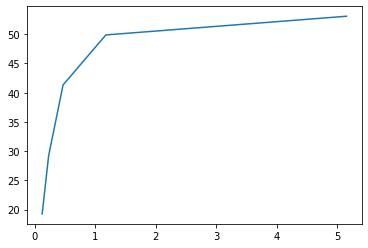

In [10]:
plt.plot(colinearity, errors)

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


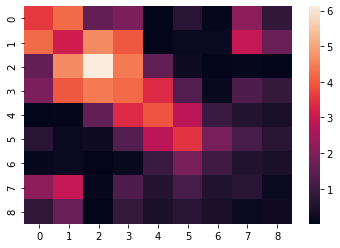

In [11]:
sns.heatmap(np.abs(y_bus - y_sparse_tls_cov));

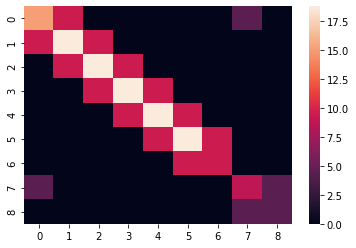

In [12]:
sns.heatmap(np.abs(y_bus));

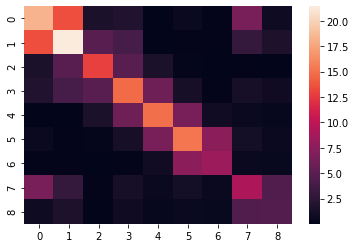

In [13]:
sns.heatmap(np.abs(y_sparse_tls_cov.toarray()));

In [14]:
n_experiments = 10
colinearity = np.empty(n_experiments)
errors = np.empty(n_experiments)

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
for k in tqdm(range(n_experiments), desc='outer loop', leave=True):
    net = pnet.create_kerber_landnetz_freileitung_2(p_load_mw=0.008, q_load_mvar=0)
    nodes = net.bus.shape[0]
    steps = 400
    load_cv = 0.5
    current_magnitude_sd = 0.000001
    voltage_magnitude_sd = 0.0001
    phase_sd = 0.0001
    volt_var = 0.0001*(k+1)
    with mlflow.start_run(run_name=str('S-TLS with covariance, voltages added random = ' + str(volt_var) + 'kW')):
        load_p, load_q = generate_gaussian_load(net.load.p_mw, net.load.q_mvar, load_cv, steps)
        controlled_net = add_load_power_control(net, load_p, load_q)
        sim_result = run_simulation(controlled_net, verbose=False)
        y_bus = make_y_bus(controlled_net)
        voltage, current = get_current_and_voltage(sim_result, y_bus)
        controlled_net.bus

        voltage = voltage[:, 1:]
        voltage = voltage + np.random.normal(0.0, volt_var, voltage.shape) + 1j*np.random.normal(1, volt_var, voltage.shape)
        y_bus = y_bus[1:, 1:]
        current = np.array(voltage @ y_bus)
        noisy_voltage = add_polar_noise_to_measurement(voltage, voltage_magnitude_sd, phase_sd)
        noisy_current = add_polar_noise_to_measurement(current, current_magnitude_sd, phase_sd)
        voltage_error, current_error = noisy_voltage - voltage, noisy_current - current

        vect_voltage = np.abs(vectorize_matrix(voltage))
        current_col = 1/np.sum((vect_voltage - np.mean(vect_voltage))**2)

        real_powers = np.multiply(voltage,current.conj())
        powers = np.multiply(noisy_voltage,noisy_current.conj())

        real_line_mat = cross_multiply_measurements(voltage)
        line_mat = cross_multiply_measurements(noisy_voltage)

        real_A_mat = make_measurements_matrix(voltage)
        A_mat = make_measurements_matrix(noisy_voltage)

        power_noise = powers - real_powers
        line_mat_noise = line_mat - real_line_mat

        b_vector = powers.reshape(powers.size)

        np.linalg.svd(voltage, compute_uv=False)

        np.mean(np.abs(current), 0)

        mlflow_params = {
            'nodes': noisy_voltage.shape[1],
            'steps': steps,
            'load_cv': load_cv,
            'current_magnitude_sd': current_magnitude_sd,
            'voltage_magnitude_sd': voltage_magnitude_sd,
            'phase_sd': phase_sd
        }

        lasso = ComplexLasso(y_bus, verbose=False, lambdas=np.logspace(-12, -1, 40), solver=cp.GUROBI)
        lasso.fit(A_mat, b_vector, True)
        best_lambda = lasso.best_trial.hyperparameters['lambda']

        sigma_power = power_covariance(noisy_voltage.reshape(noisy_voltage.size), noisy_current.reshape(noisy_current.size),
                                   voltage_magnitude_sd, phase_sd, current_magnitude_sd, phase_sd)
        voltages1 = noisy_voltage.repeat(noisy_voltage.shape[1],1).flatten()
        voltages2 = np.tile(noisy_voltage, (1, noisy_voltage.shape[1])).flatten()
        sigma_line_mat = power_covariance(voltages1, voltages2, voltage_magnitude_sd, phase_sd, voltage_magnitude_sd, phase_sd)

        inv_sigma_power = sparse.linalg.inv(sigma_power)
        inv_sigma_line_mat = sparse.linalg.inv(sigma_line_mat)

        max_iterations = 50
        abs_tol = 10e-12
        rel_tol = 10e-12
        solver = cp.GUROBI
        use_cov_matrix = True

        sparse_tls_cov = SparseTotalLeastSquare(lambda_value=best_lambda, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
        sparse_tls_cov.fit_with_vectored_data(line_mat, A_mat, b_vector, inv_sigma_line_mat, inv_sigma_power,True)

        y_sparse_tls_cov = sparse_tls_cov.fitted_admittance_matrix.conj()
        sparse_tls_cov_metrics = error_metrics(y_bus, y_sparse_tls_cov)

        sparse_tls_cov_errors = pd.Series([fro_error(y_bus.conj(), i.fitted_parameters) for i in sparse_tls_cov.iterations])
        sparse_tls_cov_targets = pd.Series([i.target_function for i in sparse_tls_cov.iterations])

        mlflow.log_param('lambda', best_lambda)
        mlflow.log_param('max_iterations', max_iterations)
        mlflow.log_param('abs_tol', abs_tol)
        mlflow.log_param('rel_tol', rel_tol)
        mlflow.log_param('solver', solver)
        mlflow.log_param('use_cov_matrix', use_cov_matrix)
        mlflow.log_params(mlflow_params)
        mlflow.log_metrics(sparse_tls_cov_metrics.__dict__)

        for i in range(len(sparse_tls_cov_errors)):
            mlflow.log_metric('fro_error_evo', value=sparse_tls_cov_errors[i], step=i)
            mlflow.log_metric('opt_cost_evo', value=sparse_tls_cov_targets[i], step=i)

        colinearity[k] = current_col
        errors[k] = sparse_tls_cov_metrics.fro_error


outer loop:   0%|          | 0/10 [00:00<?, ?it/s]No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,

  0%|          | 0/50 [00:00<?, ?it/s]/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/problems/problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(

outer loop:   0%|          | 0/10 [08:37<?, ?it/s]


SolverError: Solver 'GUROBI' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
print(errors)

In [ ]:
print(colinearity)

Colinearity and error relation

The following plot shows the Frobenius length of the error $\|Y-\tilde{Y}\|_F$ on the y axis, for each set of voltages,
represented by $\|\text{vec}(V) - \text{mean}(\text{vec}(V))\|^{-2}$, which gives an idea of the coliearity.

In [ ]:
plt.plot(colinearity, errors)

In [ ]:
sns.heatmap(np.abs(y_bus - y_sparse_tls_cov));

In [ ]:
sns.heatmap(np.abs(y_bus));

In [ ]:
sns.heatmap(np.abs(y_sparse_tls_cov.toarray()));